In [1]:
import pandas as pd
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os
import math
from matplotlib.cm import ScalarMappable
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv("/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_Model_Testing/EDP_filtered/WT_01.csv")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def plot_power_curve(ax, wind_speeds, actual_powers, expected_powers, power_curve_df):
    distances = actual_powers - expected_powers
    norm = plt.Normalize(distances.min(), distances.max())
    colors = plt.cm.viridis(norm(distances))

    ax.scatter(wind_speeds, actual_powers, c=colors, alpha=0.25, edgecolor='black', label='Measured')
    ax.plot(power_curve_df.index, power_curve_df['power_norm'], c='k', label='Standard Power Curve')
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    cbar.set_label('Distance from Power Curve')
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Power Output (kW)')
    ax.set_title('Measured Power Curve')
    ax.grid(True)
    ax.legend()

def prepare_power_curve(path_):
    df_powercurve = pd.read_csv(path_, index_col=0)

    df_pc = pd.DataFrame(index=[np.round(i, 2) for i in np.arange(0, 30, 0.01)], columns=['power_norm'])
    df_pc[df_pc.index < df_powercurve.index[0]] = 0
    df_pc[df_pc.index > df_powercurve.index[-1]] = 0
    df_pc.loc[df_powercurve.index] = df_powercurve.values.reshape(-1, 1)
    return df_pc.astype(float).interpolate(method='linear')

def plot_overview_cockpit(base_path, data = df, freq='10T'):
    power_curve_df = prepare_power_curve(base_path + 'powercurve.csv')
    power_curve_df = power_curve_df / 2000 * data['Power'].max()
    

    wind_speeds = data['Wind_speed'].values
    actual_powers = data['Power'].values

    wind_speeds = wind_speeds[~np.isnan(wind_speeds)]
    actual_powers = actual_powers[~np.isnan(actual_powers)]

    expected_powers = np.array([power_curve_df.loc[np.round(speed, 2)].values[0] for speed in wind_speeds])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plot_power_curve(axes[0], wind_speeds, actual_powers, expected_powers, power_curve_df)

    # Plot data availability
    time_index = df.index
    full_time_index = pd.date_range(time_index.min(), time_index.max(), freq=freq)
    available = np.array([int(time in time_index) for time in full_time_index])

    return power_curve_df

/tmp/ipykernel_190664/3587192314.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_index = pd.date_range(time_index.min(), time_index.max(), freq=freq)


Pearson correlation: 0.9662577323572058


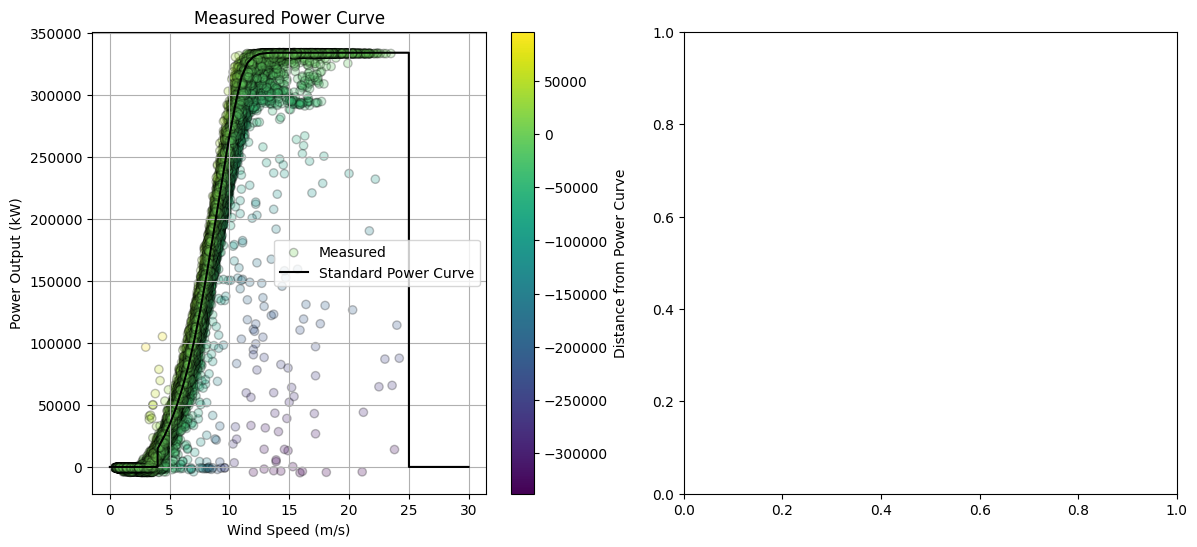

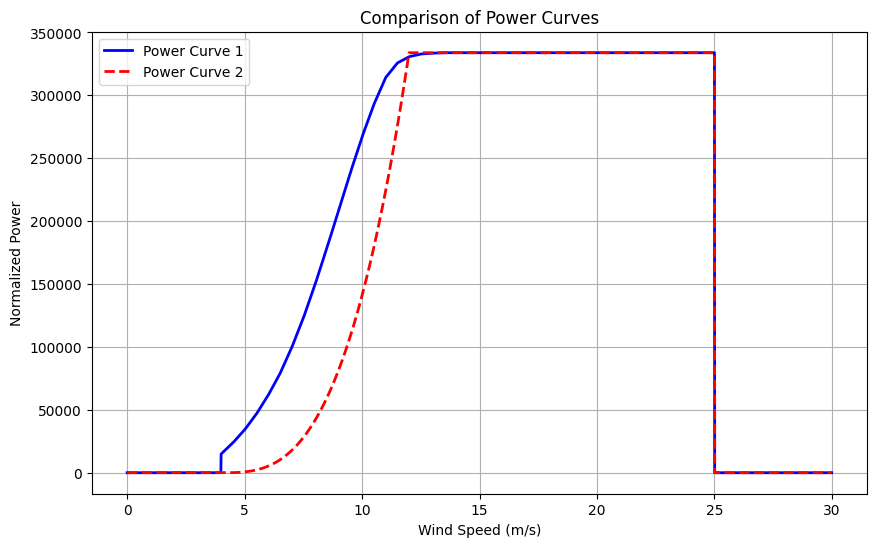

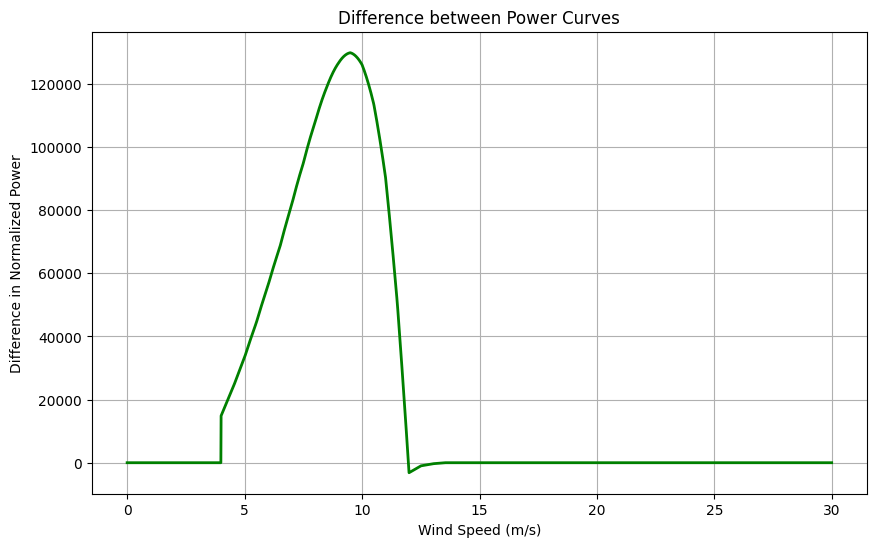

In [9]:
cut_in_speed = 4  # m/s
rated_speed = 12  # m/s
cut_out_speed = 25  # m/s
rated_power = 2000  # kW

# wind speed 0 to 30 m/s with step size 0.01
wind_speeds = np.round(np.arange(0, 30, 0.01), 2)

power_norm = np.piecewise(
    wind_speeds,
    [
        wind_speeds < cut_in_speed,
        (wind_speeds >= cut_in_speed) & (wind_speeds < rated_speed), 
        (wind_speeds >= rated_speed) & (wind_speeds <= cut_out_speed),  
        wind_speeds > cut_out_speed
    ],
    [
        0,  
        lambda v: rated_power * ((v - cut_in_speed) / (rated_speed - cut_in_speed)) ** 3, 
        rated_power,  
        0  
    ]
)

# Create a DataFrame without normalization (method 1)
power_curve = pd.DataFrame({
    "power_norm": power_norm  # Power in kW (true values)
}, index=wind_speeds)

# Normalize power curve for comparison
power_curve = power_curve / 2000 * df['Power'].max()

# Prepare the power curve from the file (method 2)
base_path = "/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_EDA/"

pc = plot_overview_cockpit(base_path, data=df)

# Print MSE between both curves
# print_mse(df, power_curve)

# Plot the comparison of both power curves
difference = pc['power_norm'] - power_curve['power_norm']
correlation = pc['power_norm'].corr(power_curve['power_norm'])
print(f"Pearson correlation: {correlation}")

# Plot the power curves for comparison
plt.figure(figsize=(10, 6))
plt.plot(pc.index, pc['power_norm'], label='Power Curve 1', color='blue', linestyle='-', linewidth=2)
plt.plot(power_curve.index, power_curve['power_norm'], label='Power Curve 2', color='red', linestyle='--', linewidth=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Normalized Power')
plt.title('Comparison of Power Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(pc.index, difference, label='Difference', color='green', linestyle='-', linewidth=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Difference in Normalized Power')
plt.title('Difference between Power Curves')
plt.grid(True)
plt.show()
